# DS 1 - LABORATORIO 05

### Juan Lorthiois       -  18771
### Roberto Castillo    -  18546
### Alexis Estrada       -  181099

#### Incisos 1 a 3:

A continuacion se importan los datos, y se inicia con la limpieza de los mismos en preparación para el EDA y la aplicacion del agoritmo clasificador.

#### Importacion de librerías e importación de los datos como DataFrame de Pandas

In [308]:
# Importando librerias

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jlort\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jlort\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [309]:
#Importando los datos
Df = pd.read_csv("train.csv")

In [310]:
Df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [311]:
Df.isna().sum()  #encontrar columnas que tienen Nas.

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [312]:
Df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


### Ideas preliminares:

Acabamos de ver que hay Nas, sin embargo la mayoría se concentran en a variable "location". Antes de decidir cómo resolver este inconveniente, se trabajará primero en limpiar los "tweets" mostrados en la variable "text". Posteriormente a este data cleaning, se procederá a decidir si se preservan o no las variables "location" y "keyword".

#### Limpieza de Tweets

In [313]:
#preparamos una funcion que se encargue de limpiar cada tweet

def Tweet_prep(linea):
    
    linea = linea.lower() #poner todo en minusculas
    linea = re.sub(r'http\S+', '', linea) #quitar urls
    linea = re.sub(r"[^a-zA-Z 911]", "", linea) #quitar cualquier cosa que no sean letras o el 911 (tel de emergencias en USA)
    linea = re.sub(' +', ' ',linea) #eliminando cualquier espacio doble o más
    tokens= word_tokenize(linea) #Separamos el String en sus distintas palabras y las ingresamos a un listado de 'Tokens'.
    nuevos_tokens = []
    for i in tokens:
        if i not in stop_words:
            nuevos_tokens.append(i)
    tokens = nuevos_tokens
    
    return tokens

In [314]:
Tweets_listos = [Tweet_prep(linea) for linea in Df.loc[:, 'text']]  #La lista de listas de tweets listos para ser reasignados al Df

In [315]:
len(Df.loc[:, 'text']) #Verificando que las listas tengan el mismo tamaño

7613

In [316]:
len(Tweets_listos)

7613

In [317]:
for i in range(0, len(Tweets_listos)):    #Agregamos las listas de palabras procesadas y listas para su analisis
    Df.at[i, 'text'] = Tweets_listos[i]

In [318]:
Df.head(10)  #listo el Df con los tweets procesados!

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[1, people, receive, wildfires, evacuation, or...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
5,8,NaN,NaN,"[rockyfire, update, california, hwy, closed, d...",1
6,10,NaN,NaN,"[flood, disaster, heavy, rain, causes, flash, ...",1
7,13,NaN,NaN,"[im, top, hill, see, fire, woods]",1
8,14,NaN,NaN,"[theres, emergency, evacuation, happening, bui...",1
9,15,NaN,NaN,"[im, afraid, tornado, coming, area]",1


#### Frecuencias de palabras y bigramas y trigramas

A continuacion evaluamos las palabras mas frecuentes en el Df general, pero tambien diferenciando entre tweets que se refieren a desastres reales y los que no.

Además, para el análisis en bigramas y trigramas procedemos de manera similar a lo indicado en la pagina: https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

In [319]:
#Separamos el dataframe en desastres reales y falsos para uso futuro

criterio = Df['target'] == 0

Df_no_desastres = Df[criterio]

Df_solo_desastres = Df[~criterio]


In [320]:
#Ahora contamos la ocurrencia de palabras en el Df, Df_no_desastres, y Df_solo_desastres

Frecuencias_Df = pd.value_counts(np.hstack(Df['text']))
Frecuencias_Df_no_desastres = pd.value_counts(np.hstack(Df_no_desastres['text']))
Frecuencias_Df_solo_desastres = pd.value_counts(np.hstack(Df_solo_desastres['text']))

In [321]:
Frecuencias_Df  #Listamos las frecuencias de las palabras/unigramas del dataframe general

1                  511
like               344
im                 302
amp                299
fire               250
                  ... 
windowgatribble      1
contrasts            1
foreboding           1
expansive            1
symptoms             1
Length: 17139, dtype: int64

In [322]:
Frecuencias_Df_solo_desastres  #listamos las frecuencias del dataframe que solo contienen desastres 'reales'

1             295
fire          179
news          133
via           121
disaster      116
             ... 
riveeeeeer      1
iiii            1
swollen         1
idiots          1
flip            1
Length: 8903, dtype: int64

In [323]:
Frecuencias_Df_no_desastres  #listamos las frecuencias del Df donde no hay desastres reales

like                252
im                  245
1                   216
amp                 193
new                 170
                   ... 
dealing               1
surgery               1
knife                 1
improvement           1
explodingkittens      1
Length: 12094, dtype: int64

#### Bigramas y Trigramas

In [324]:
Df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[1, people, receive, wildfires, evacuation, or...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [325]:
#Antes de empezar, creamos un dataset exclusivo para este proposito. 
#Es igual al Df depurado de stopwords etc, pero en vez de listas ahora unimos estas palabras en strings para que
#sea mas facil trabajar con sklearn

df_ngrams = Df.copy()  

new_vals = []
for i in range(0, len(df_ngrams)):
    new_vals.append(' '.join(df_ngrams.iloc[i]['text']))

text_col = {'text': new_vals}

df_ngrams['text'] = pd.DataFrame(text_col)

In [326]:
df_ngrams.head()  #listo!


In [ ]:
df_modelo = df_ngrams.copy()

In [327]:
#importamos librerias requeridas para esta etapa

from sklearn.feature_extraction.text import CountVectorizer




In [328]:


c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))  #instanciando el objeto CountVectorizer

# Generamos la matriz de ngramas, esto no debería de ser muy dificil ya que las frases ya vienen 'limpias'
ngrams = c_vec.fit_transform(df_ngrams['text'])


In [329]:
# Evaluamos las frecuencias de repetición de los bigramas y trigrmas que mas se repiten
count_values = ngrams.toarray().sum(axis=0)


# listamos los bigramas y trigramas mediante un dataframe ordenados por sus respectivas frecuencias
vocab = c_vec.vocabulary_

df_ngrams = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)  #generamos el nuevo dataframe
            ).rename(columns={0: 'Frecuencia', 1:'bigrama/trigrama'})

In [330]:
df_ngrams.head(20) #Listos los bigramas/trigramas

,Frecuencia,bigrama/trigrama
0,59,suicide bomber
1,56,burning buildings
2,43,youtube video
3,43,gon na
4,42,liked youtube video
5,42,liked youtube
6,41,northern california
7,39,oil spill
8,39,cross body
9,35,wan na


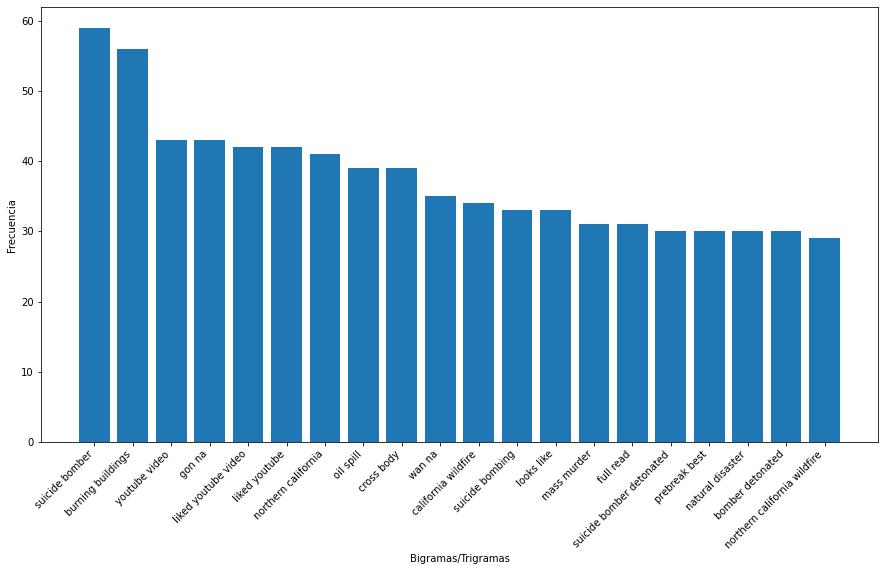

In [331]:
#Para una mejor visualización hacemos un barplot con los bigramas y trigramas y sus frecuecnias correspondientes

datos_plot = df_ngrams.iloc[0:20][['Frecuencia', 'bigrama/trigrama']]
plt.figure(figsize=(15,8))

plt.bar(datos_plot['bigrama/trigrama'], datos_plot['Frecuencia'])

plt.xticks(rotation=45, ha="right")

plt.xlabel('Bigramas/Trigramas')
plt.ylabel('Frecuencia')
plt.show()

### Analisis Exploratorio

In [332]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

#### Frecuencia de las palabras en los tweets

In [333]:
Frecuencias_Df

1                  511
like               344
im                 302
amp                299
fire               250
                  ... 
windowgatribble      1
contrasts            1
foreboding           1
expansive            1
symptoms             1
Length: 17139, dtype: int64


#### Nube de palabras

##### El dataset completo

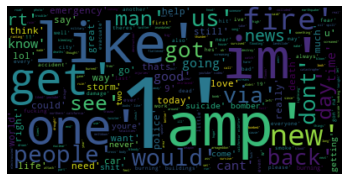

In [334]:
words = list(map(str, Df['text']))

result = ' '.join(words)

wordcloud = WordCloud().generate(result)

#Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("firs.png")


##### Tweets normales 

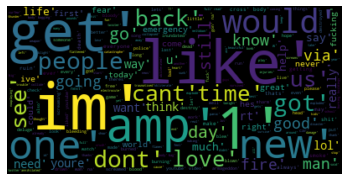

In [335]:
words = list(map(str, Df_no_desastres['text']))

result = ' '.join(words)

wordcloud = WordCloud().generate(result)

#Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("normales.png")

##### Tweets con desastres

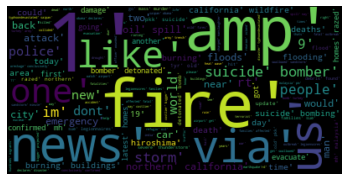

In [336]:
words = list(map(str, Df_solo_desastres['text']))

result = ' '.join(words)

wordcloud = WordCloud().generate(result)

#Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("desastres.png")

#### Histogramas

##### Tweets normales

In [337]:
# Opcional para establecer un limite (10)
Frecuencias_Df_no_desastres = Frecuencias_Df_no_desastres[:10]

Frecuencias_Df_no_desastres = pd.DataFrame(Frecuencias_Df_no_desastres)

<AxesSubplot:title={'center':'Top 10 Word Frequency'}, xlabel='Word', ylabel='Count'>

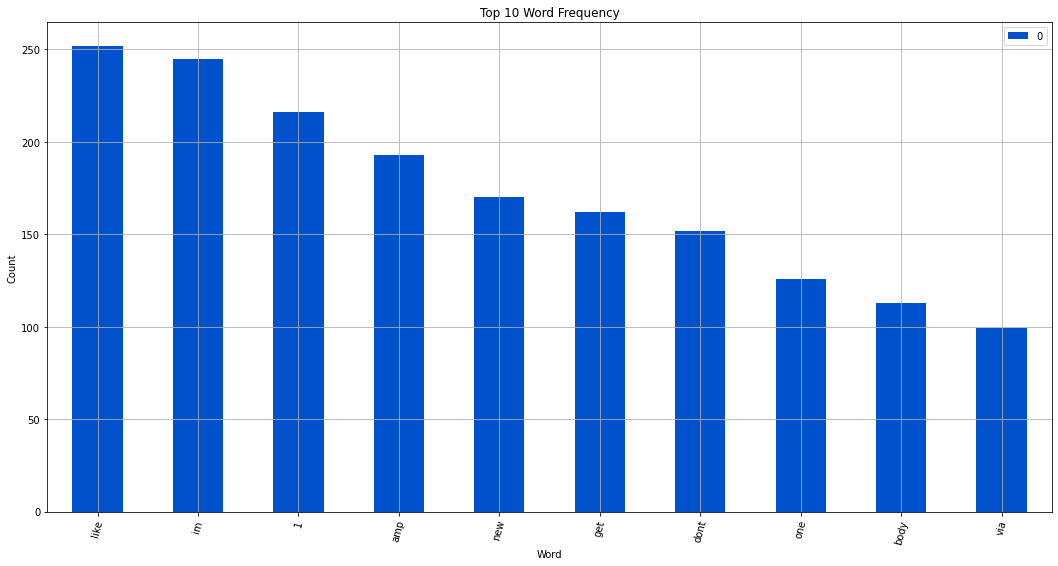

In [338]:
# Grafica de barras
Frecuencias_Df_no_desastres.plot.bar(figsize=(18,9),xlabel="Word",ylabel="Count",title="Top 10 Word Frequency",rot=75,color=["#0052CC"],grid=True)

##### Tweets con desastres

In [339]:
# Opcional para establecer un limite (10)
Frecuencias_Df_solo_desastres = Frecuencias_Df_solo_desastres[:10]

Frecuencias_Df_solo_desastres = pd.DataFrame(Frecuencias_Df_solo_desastres)

<AxesSubplot:title={'center':'Disaster Top 10 Word Frequency'}, xlabel='Word', ylabel='Count'>

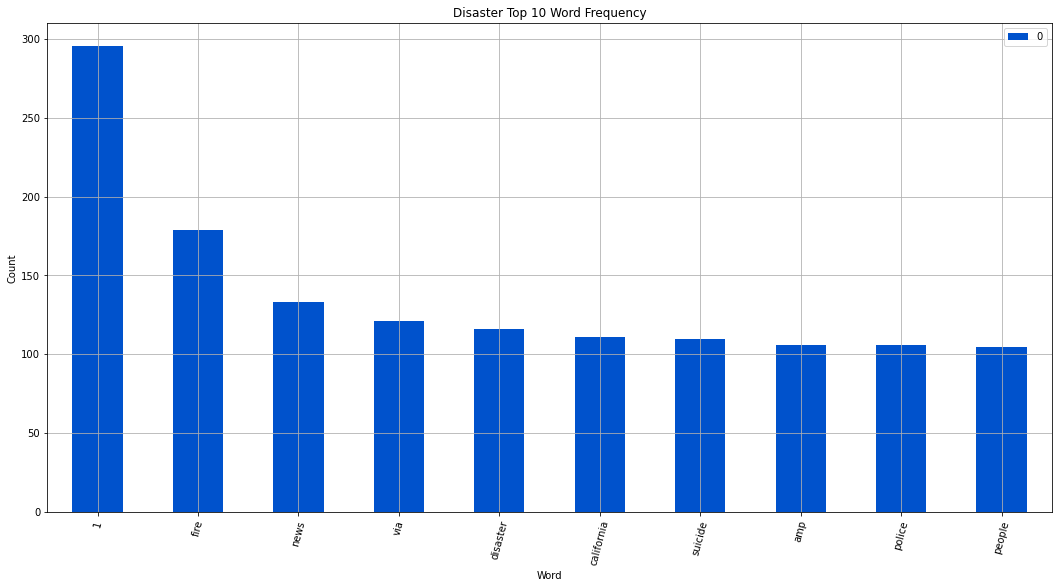

In [340]:
# Grafica de barras
Frecuencias_Df_solo_desastres.plot.bar(figsize=(18,9),xlabel="Word",ylabel="Count",title="Disaster Top 10 Word Frequency",rot=75,color=["#0052CC"],grid=True)

##### Se clasifican los tweets por positivo, negativo o neutro

In [341]:
Df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[1, people, receive, wildfires, evacuation, or...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [342]:
from textblob import TextBlob

def useSentimentPolarity(tweet):
    listToString = ' '.join(tweet)
    watchSentiment = TextBlob(listToString)

    if watchSentiment.sentiment.polarity >= 0.05:
        return ['positivo', watchSentiment.sentiment.polarity ]
    elif watchSentiment.sentiment.polarity <= - 0.05:
        return ['negativo', watchSentiment.sentiment.polarity ]
    else:
        return ['neutral', watchSentiment.sentiment.polarity ] 

In [343]:
polarity = []
polarity_value = []
for i in range(0, len(Df)):
    polarity.append(useSentimentPolarity(Df.loc[i, 'text'])[0])
    polarity_value.append(useSentimentPolarity(Df.loc[i, 'text'])[1])

Df['polarity'] = polarity
Df['polarity_value'] = polarity_value
Df.head()

,id,keyword,location,text,target,polarity,polarity_value
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1,neutral,0.0
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,positivo,0.1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1,negativo,-0.1
3,6,NaN,NaN,"[1, people, receive, wildfires, evacuation, or...",1,neutral,0.0
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1,neutral,0.0


##### Histograma con la cantidad de tweets positivos, negativos y neutros.

(array([3928.,    0.,    0.,    0.,    0., 2207.,    0.,    0.,    0.,
        1478.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

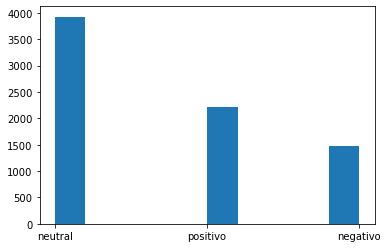

In [344]:
plt.hist(Df['polarity'])

##### Los 10 tweets más negativos

In [345]:
Df.sort_values(by=['polarity_value']).head(10)

,id,keyword,location,text,target,polarity,polarity_value
426,617,arsonist,ss,"[hif, trick, think, nasty, things]",0,negativo,-1.0
454,657,attack,Freeport IL. USA,"[horrific, attack, wife, muslim, italy, livele...",1,negativo,-1.0
5799,8278,rioting,NaN,"[aelinrhee, group, mascara, smeared, girls, ri...",1,negativo,-1.0
6672,9563,thunder,"South Carolina, USA","[worst, part, seeing, lightning, trying, guess...",0,negativo,-1.0
3557,5083,famine,Massachusetts,"[russia, destroys, food, people, go, hungry, o...",1,negativo,-1.0
7195,10307,weapon,NaN,"[abcnews, nuclear, bomb, terrible, weapon]",1,negativo,-1.0
4849,6908,mass%20murderer,Earth-616,"[creelyou, must, think, im, real, moron, flag,...",0,negativo,-1.0
501,726,attacked,"Los Angeles, CA","[envw9, nickcocofree, juliedicaro, jdabe, wors...",0,negativo,-1.0
166,241,airplane%20accident,Fashion Heaven. IG: TMId_,"[phone, looks, like, car, ship, airplane, acci...",0,negativo,-1.0
3717,5285,fear,"Thibodaux, LA","[worst, fear]",0,negativo,-1.0


##### Los 10 tweets más positivos

In [346]:
Df.sort_values(by='polarity_value', ascending=False).head(10)

,id,keyword,location,text,target,polarity,polarity_value
4819,6860,mass%20murder,Los Angeles,"[rt, owenrbroadhurst, rt, juanmthompson, hour,...",1,positivo,1.0
5116,7296,nuclear%20reactor,NaN,"[check, awesome, profile, ges, swimming, robot...",0,positivo,1.0
6660,9547,threat,NaN,"[end, australias, best, burger, via, newscomauhq]",0,positivo,1.0
128,184,aftershock,304,"[remembering, going, die, best, way, know, avo...",0,positivo,1.0
2046,2936,danger,Atlanta Georgia,"[nuggets, fettilootch, slanglucci, oppressions...",0,positivo,1.0
6440,9215,suicide%20bombing,NaN,"[malik, saadthe, best, police, officer, produc...",1,positivo,1.0
5298,7568,outbreak,"Stockholm, Sweden","[senatemajldr, lets, try, best, prevent, anoth...",1,positivo,1.0
47,67,ablaze,NaN,"[building, perfect, tracklist, life, leave, st...",0,positivo,1.0
413,599,arsonist,Atlanta,"[nowplaying, arsonist, mc, impressed, arsonist...",0,positivo,1.0
6291,8987,storm,Santiago de Chile,"[doves, storm, greatest, denier, electric, pro...",1,positivo,1.0


## Entrenamiento del modelo y validacion

Retomamos el dataset df_ngrams ya que este contiene las palabras como cadenas de textos depuradas de caracterse especiales.
Esto facilita trabajar con las opciones que ofrece Tensorflow/keras para mapear cada palabra a un numero distinto.


In [409]:
df_modelo.head()

,id,keyword,location,text,target,negatividad
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0.1
2,5,NaN,NaN,residents asked shelter place notified officer...,1,-0.1
3,6,NaN,NaN,1 people receive wildfires evacuation orders c...,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0.0


In [410]:
len(df_modelo)

7613

Lo primero es separa los datos en los conjunto de entrenmiento, validacion y prueba

In [411]:
#Preparamos el objeto que nos permitirá mapear numeros a cada token
lista_palabras = [palabras for palabras in df_modelo['text']]
tokenizer = Tokenizer()  #como tweeter permite un maximo de 280 palabras esta es la cantidad que elegimos por ahora
tokenizer.fit_on_texts(lista_palabras) #Preparamos la asignacion de numeros con palabras

In [412]:
#Preparamos los dataframes

df_train=df_modelo.sample(frac=0.8,random_state=11235) #random state is a seed value
temp = df_modelo.drop(df_train.index)
df_test = temp.sample(frac = 0.5, random_state = 2357)
df_val = temp.drop(df_test.index)

In [413]:
len(df_test) + len(df_train) + len(df_val)  #Solo chequeando que todo esté bien

7613

Procesamos los datos en ambos conjuntos para que esten listos para el entrenamiento y prueba del modelo

In [414]:
lista_palabras_train = [palabras for palabras in df_train['text']]
lista_palabras_val = [palabras for palabras in df_val['text']]
lista_palabras_test = [palabras for palabras in df_test['text']]

In [415]:
#Preparamos X_test y X_train

X_train = tokenizer.texts_to_sequences(lista_palabras_train) #Asignamos cada palabra a un numero
X_val = tokenizer.texts_to_sequences(lista_palabras_val)
X_test = tokenizer.texts_to_sequences(lista_palabras_test) #Asignamos cada palabra a un numero

In [416]:
# calculamos la longitud promedio de una lista para cuando haya que aplicar padding

long =[len(lista) for lista in lista_palabras]
sum(long)/(len(lista_palabras))  #esta es la longitud promedio de una lista, usremos 75 para el padding
    


64.19374753710758

In [418]:
#Revisamos el output
print('Muestra X_train: ', X_train[1])
print('Muestra X_val: ', X_val[2])
print('Muestra X_test: ', X_test[3])



Muestra X_train:  [8632, 9, 41, 2439, 1093, 51, 76, 2080, 4250, 4927, 1328]
Muestra X_val:  [703, 496, 2630, 126, 2631, 3235, 545, 497, 115, 496, 2630, 169, 71, 169, 71, 6377, 152]
Muestra X_test:  [733, 734, 446, 1530, 5359, 1473, 1464, 1496, 78]


In [419]:
y_train = [target for target in df_train['target']] #Preparamos la lista de labels para el entrenamiento
y_val = [target for target in df_val['target']]
y_test = [target for target in df_test['target']]

In [420]:
#Revisamos el output
print('Muestra y_train: ', y_train[1])
print('Muestra y_val: ', y_val[2])
print('Muestra y_test: ', y_test[3])

Muestra y_train:  0
Muestra y_val:  1
Muestra y_test:  0


In [421]:
len(X_val)

761

In [422]:
len(y_val)

761

Todo parece estar bien con los datos. hacemos el padding y procedemos con el entrenamiento del modelo

In [423]:
X_train = sequence.pad_sequences(X_train, maxlen = 75)
X_val = sequence.pad_sequences(X_val, maxlen = 75)
X_test = sequence.pad_sequences(X_test, maxlen = 75)

In [424]:
#Solo estandarizando los formatos para que sean compatibles

y_train = np.array(y_train, dtype='int64')
y_val = np.array(y_val, dtype='int64')
y_test = np.array(y_test, dtype='int64')

In [425]:
y_val[:5]  #Formato ok!

array([1, 1, 1, 0, 0], dtype=int64)

Preparamos el modelo de la misma manera que el ejemplo revisado en clase, esto debido a que este tambien es un problema de clasificacion bienaria, recordemos que el enucniado del laboratorio estipula que el objetivo es clasificar los tweets dependiendo si se refieren a un incidente real o no. Si es necesario se ajustaran los hiperparametrso mas tarde


In [426]:
#Preparamos el modelo con su capa de activacion

modelo = Sequential()
modelo.add(Embedding(20000, 128))
modelo.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
modelo.add(Dense(1, activation='sigmoid'))

In [427]:
#compilamos el modelo

modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [428]:
modelo.fit(X_train, y_train,
          batch_size=16,
          epochs=10,
          verbose=2,
          validation_data=(X_val, y_val))

Epoch 1/10
381/381 - 80s - loss: 0.5198 - accuracy: 0.7440 - val_loss: 0.4563 - val_accuracy: 0.7911 - 80s/epoch - 210ms/step
Epoch 2/10
381/381 - 77s - loss: 0.2704 - accuracy: 0.8915 - val_loss: 0.5263 - val_accuracy: 0.7858 - 77s/epoch - 202ms/step
Epoch 3/10
381/381 - 70s - loss: 0.1360 - accuracy: 0.9473 - val_loss: 0.5715 - val_accuracy: 0.7661 - 70s/epoch - 183ms/step
Epoch 4/10
381/381 - 70s - loss: 0.0802 - accuracy: 0.9696 - val_loss: 0.7216 - val_accuracy: 0.7661 - 70s/epoch - 184ms/step
Epoch 5/10
381/381 - 71s - loss: 0.0572 - accuracy: 0.9747 - val_loss: 0.7324 - val_accuracy: 0.7595 - 71s/epoch - 185ms/step
Epoch 6/10
381/381 - 71s - loss: 0.0410 - accuracy: 0.9818 - val_loss: 0.9986 - val_accuracy: 0.7438 - 71s/epoch - 187ms/step
Epoch 7/10
381/381 - 69s - loss: 0.0420 - accuracy: 0.9814 - val_loss: 0.8637 - val_accuracy: 0.7543 - 69s/epoch - 182ms/step
Epoch 8/10
381/381 - 70s - loss: 0.0338 - accuracy: 0.9837 - val_loss: 1.0904 - val_accuracy: 0.7346 - 70s/epoch - 183

Listo! Ya se entreno el modelo, ahora obtenems las metricas correspondientes al modelo respecto al conjunto de prueba

In [429]:
perdida, exactitud = modelo.evaluate(X_test, y_test,
                            batch_size=64,
                            verbose=2)

print('Pérdida total:', perdida)
print('Exactitud :', exactitud)

12/12 - 0s - loss: 1.0913 - accuracy: 0.7769 - 395ms/epoch - 33ms/step
Pérdida total: 1.0912870168685913
Exactitud : 0.7769029140472412


## Repitiendo el experimento/entrenamiento, esta vez incluyendo la variable numerica "polarity" creada anteriormente

In [497]:
df_modelo.head()

,id,keyword,location,text,target,negatividad
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0.1
2,5,NaN,NaN,residents asked shelter place notified officer...,1,-0.1
3,6,NaN,NaN,1 people receive wildfires evacuation orders c...,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0.0


In [498]:
df_modelo['negatividad'] = Df['polarity_value']  #agregamos la negatividad del tweet

In [499]:
df_modelo.head()

,id,keyword,location,text,target,negatividad
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0.1
2,5,NaN,NaN,residents asked shelter place notified officer...,1,-0.1
3,6,NaN,NaN,1 people receive wildfires evacuation orders c...,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0.0


In [500]:
#Preparamos el objeto que nos permitirá mapear numeros a cada token
lista_palabras = [palabras for palabras in df_modelo['text']]
tokenizer = Tokenizer()  #como tweeter permite un maximo de 280 palabras esta es la cantidad que elegimos por ahora
tokenizer.fit_on_texts(lista_palabras) #Preparamos la asignacion de numeros con palabras

In [501]:
#Preparamos los dataframes

df_train=df_modelo.sample(frac=0.8,random_state=11235) #random state is a seed value
temp = df_modelo.drop(df_train.index)
df_test = temp.sample(frac = 0.5, random_state = 2357)
df_val = temp.drop(df_test.index)

In [502]:
#resetear los indices de los df
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [503]:
lista_palabras_train = [palabras for palabras in df_train['text']]
lista_palabras_val = [palabras for palabras in df_val['text']]
lista_palabras_test = [palabras for palabras in df_test['text']]

In [504]:
#Preparamos X_test X_val, y X_test

X_train = tokenizer.texts_to_sequences(lista_palabras_train) #Asignamos cada palabra a un numero
X_val = tokenizer.texts_to_sequences(lista_palabras_val)
X_test = tokenizer.texts_to_sequences(lista_palabras_test) #Asignamos cada palabra a un numero

In [505]:
y_train = [target for target in df_train['target']] #Preparamos la lista de labels para el entrenamiento
y_val = [target for target in df_val['target']]
y_test = [target for target in df_test['target']]

In [506]:
len(X_train)

6090

Hasta ahora todo ha sido casi igual al caso anterior, ahora agregamos la negatividad a cada lista de datos:

In [507]:
#agergando la 'negatividad' al conjunto

for i in range(0,len(X_train)):
    X_train[i].append(-df_train.loc[i, 'negatividad'] if df_train.loc[i, 'negatividad'] < 0 else 0)
    
for i in range(0,len(X_val)):
    X_val[i].append(-df_val.loc[i, 'negatividad'] if df_val.loc[i, 'negatividad'] < 0 else 0)
    
for i in range(0, len(X_test)):
    X_test[i].append(-df_test.loc[i, 'negatividad'] if df_test.loc[i, 'negatividad'] < 0 else 0)



In [508]:
X_train[45] #todo listo!

[16778, 4050, 2328, 16779, 16780, 16781, 305, 16782, 16783, 16784, 0]

Los datos estan listos, ahora reentrenamos el modelo igual que en el caso anterior poor propositos de comparacion

In [509]:
X_train = sequence.pad_sequences(X_train, maxlen = 75)
X_val = sequence.pad_sequences(X_val, maxlen = 75)
X_test = sequence.pad_sequences(X_test, maxlen = 75)

In [510]:
#Solo estandarizando los formatos para que sean compatibles

y_train = np.array(y_train, dtype='int64')
y_val = np.array(y_val, dtype='int64')
y_test = np.array(y_test, dtype='int64')

In [511]:
X_test.shape

(762, 75)

In [512]:
y_val.shape

(761,)

In [513]:
#Preparamos el modelo con su capa de activacion

modelo = Sequential()
modelo.add(Embedding(20000, 128))
modelo.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
modelo.add(Dense(1, activation='sigmoid'))

In [514]:
#compilamos el modelo

modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [515]:
modelo.fit(X_train, y_train,
          batch_size=16,
          epochs=10,
          verbose=2,
          validation_data=(X_val, y_val))

Epoch 1/10
381/381 - 73s - loss: 0.5235 - accuracy: 0.7391 - val_loss: 0.4749 - val_accuracy: 0.7845 - 73s/epoch - 193ms/step
Epoch 2/10
381/381 - 69s - loss: 0.2806 - accuracy: 0.8865 - val_loss: 0.4913 - val_accuracy: 0.7819 - 69s/epoch - 181ms/step
Epoch 3/10
381/381 - 69s - loss: 0.1440 - accuracy: 0.9479 - val_loss: 0.6551 - val_accuracy: 0.7687 - 69s/epoch - 181ms/step
Epoch 4/10
381/381 - 69s - loss: 0.0937 - accuracy: 0.9655 - val_loss: 0.7495 - val_accuracy: 0.7648 - 69s/epoch - 181ms/step
Epoch 5/10
381/381 - 69s - loss: 0.0648 - accuracy: 0.9742 - val_loss: 0.7852 - val_accuracy: 0.7556 - 69s/epoch - 181ms/step
Epoch 6/10
381/381 - 69s - loss: 0.0490 - accuracy: 0.9795 - val_loss: 1.0370 - val_accuracy: 0.7464 - 69s/epoch - 181ms/step
Epoch 7/10
381/381 - 69s - loss: 0.0424 - accuracy: 0.9814 - val_loss: 0.8968 - val_accuracy: 0.7582 - 69s/epoch - 181ms/step
Epoch 8/10
381/381 - 69s - loss: 0.0336 - accuracy: 0.9831 - val_loss: 1.3074 - val_accuracy: 0.7569 - 69s/epoch - 181

In [516]:
perdida, exactitud = modelo.evaluate(X_test, y_test,
                            batch_size=64,
                            verbose=2)

print('Pérdida total:', perdida)
print('Exactitud :', exactitud)

12/12 - 0s - loss: 1.0771 - accuracy: 0.7638 - 392ms/epoch - 33ms/step
Pérdida total: 1.0771321058273315
Exactitud : 0.7637795209884644
